<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Importing libraries

In [473]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer, f1_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode

import xgboost as xgb

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import FeatureImportances

from fancyimpute import IterativeImputer

import missingno as msgno

import warnings

warnings.filterwarnings("ignore")

sns.set_palette("Purples")
np.random.seed(42)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Useful functions

Space for defining some useful handy functions.

In [476]:
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum()
    summary_df['missing%'] = (df.isna().sum())/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    return summary_df

f2_scorer = make_scorer(fbeta_score, beta=2)
f05_scorer = make_scorer(fbeta_score, beta=0.5)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Loading the data

The data comes from **Kaggle.com**, the competition objective was to make a model predicting whether the customer is important for the company or not.<br><br>
Before making the classification model I am going to make a little bit of **Exploratory Data Analysis**, searching for some patterns and finding the most crucial features.<br><br>
After that, I will proceed to classification problem.

In [479]:
train_df = pd.read_csv("data/train_df.csv")
train_df.drop_duplicates(inplace=True)
train_df.head()

id  purchase_amount  asset_amount  average_ratio  personal_id_1  \
0   0          62978.0         64016      87.170255           1256   
1   1          66790.0         64497      83.609102            666   
2   2          57788.0        111404      58.986180           1621   
3   3          59729.0         63983      72.702121           1731   
4   4          50533.0         98623      82.218856            801   

   personal_id_2  age    area       job_type  phone  ...  \
0             86   44     NaN       Salaried      1  ...   
1             86   30  5318.0       Salaried      1  ...   
2            120   36  5954.0  Self employed      1  ...   
3             51   27  7263.0            NaN      1  ...   
4             86   40  6270.0            NaN      1  ...   

   average_favorite_score  card_history_period  score_1  score_2  score_3  \
0                0.010922             0.048340        0        7        0   
1                1.687598             1.701259        0        0        6   
2                0.001265             3.483625        0        9        6   
3                0.015441             3.338835        0        1        2   
4                0.001283             0.067355        0        2        0   

   score_4  total_amount_1  total_amount_2  total_amount_3  important_customer  
0      0.0           58620           10590            1392                   0  
1      0.0           70809            9575             889                   0  
2      0.0           55294           38319             779                   0  
3      0.0            1972            9314            2081                   0  
4      0.0            4942           10484            1772                   0  

[5 rows x 28 columns]

In [481]:
summary(train_df).style.background_gradient(cmap='Greens')

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Dealing with missing data

Missing data appears in 8 columns, around 10% each. I am going to decide what to do with this after feature selection.

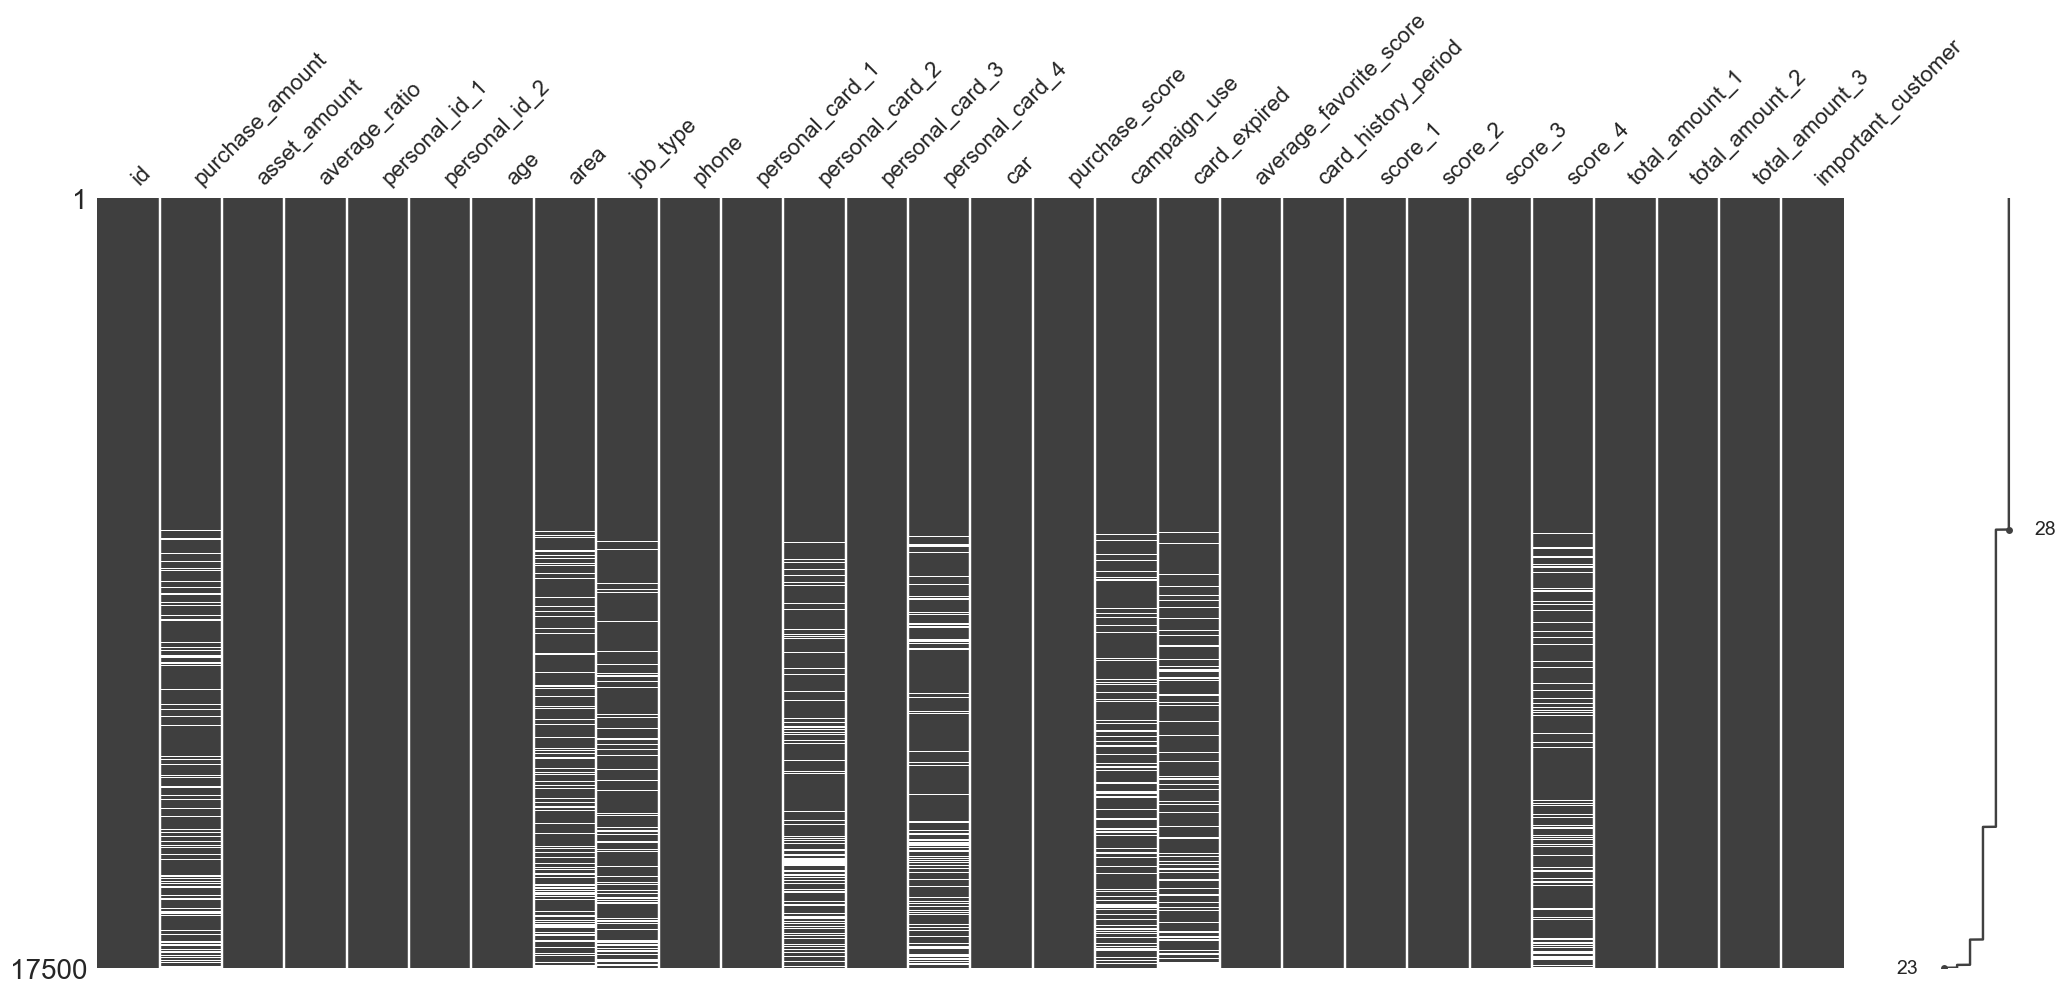

In [179]:
msgno.matrix(train_df, sort="descending")
plt.show()

In [181]:
nan_counts = train_df.isna().sum(axis=1)
nan_counts.value_counts()

0    7537
1    6755
2    2561
3     575
4      66
5       6
Name: count, dtype: int64

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Let's see how the data looks like

This type of vizualization sometimes creates more insights that the histogram.<br><br>

What I can see is that important customers are evenly distributed across single features with the others, the pattern must be searched for in a higher dimension.

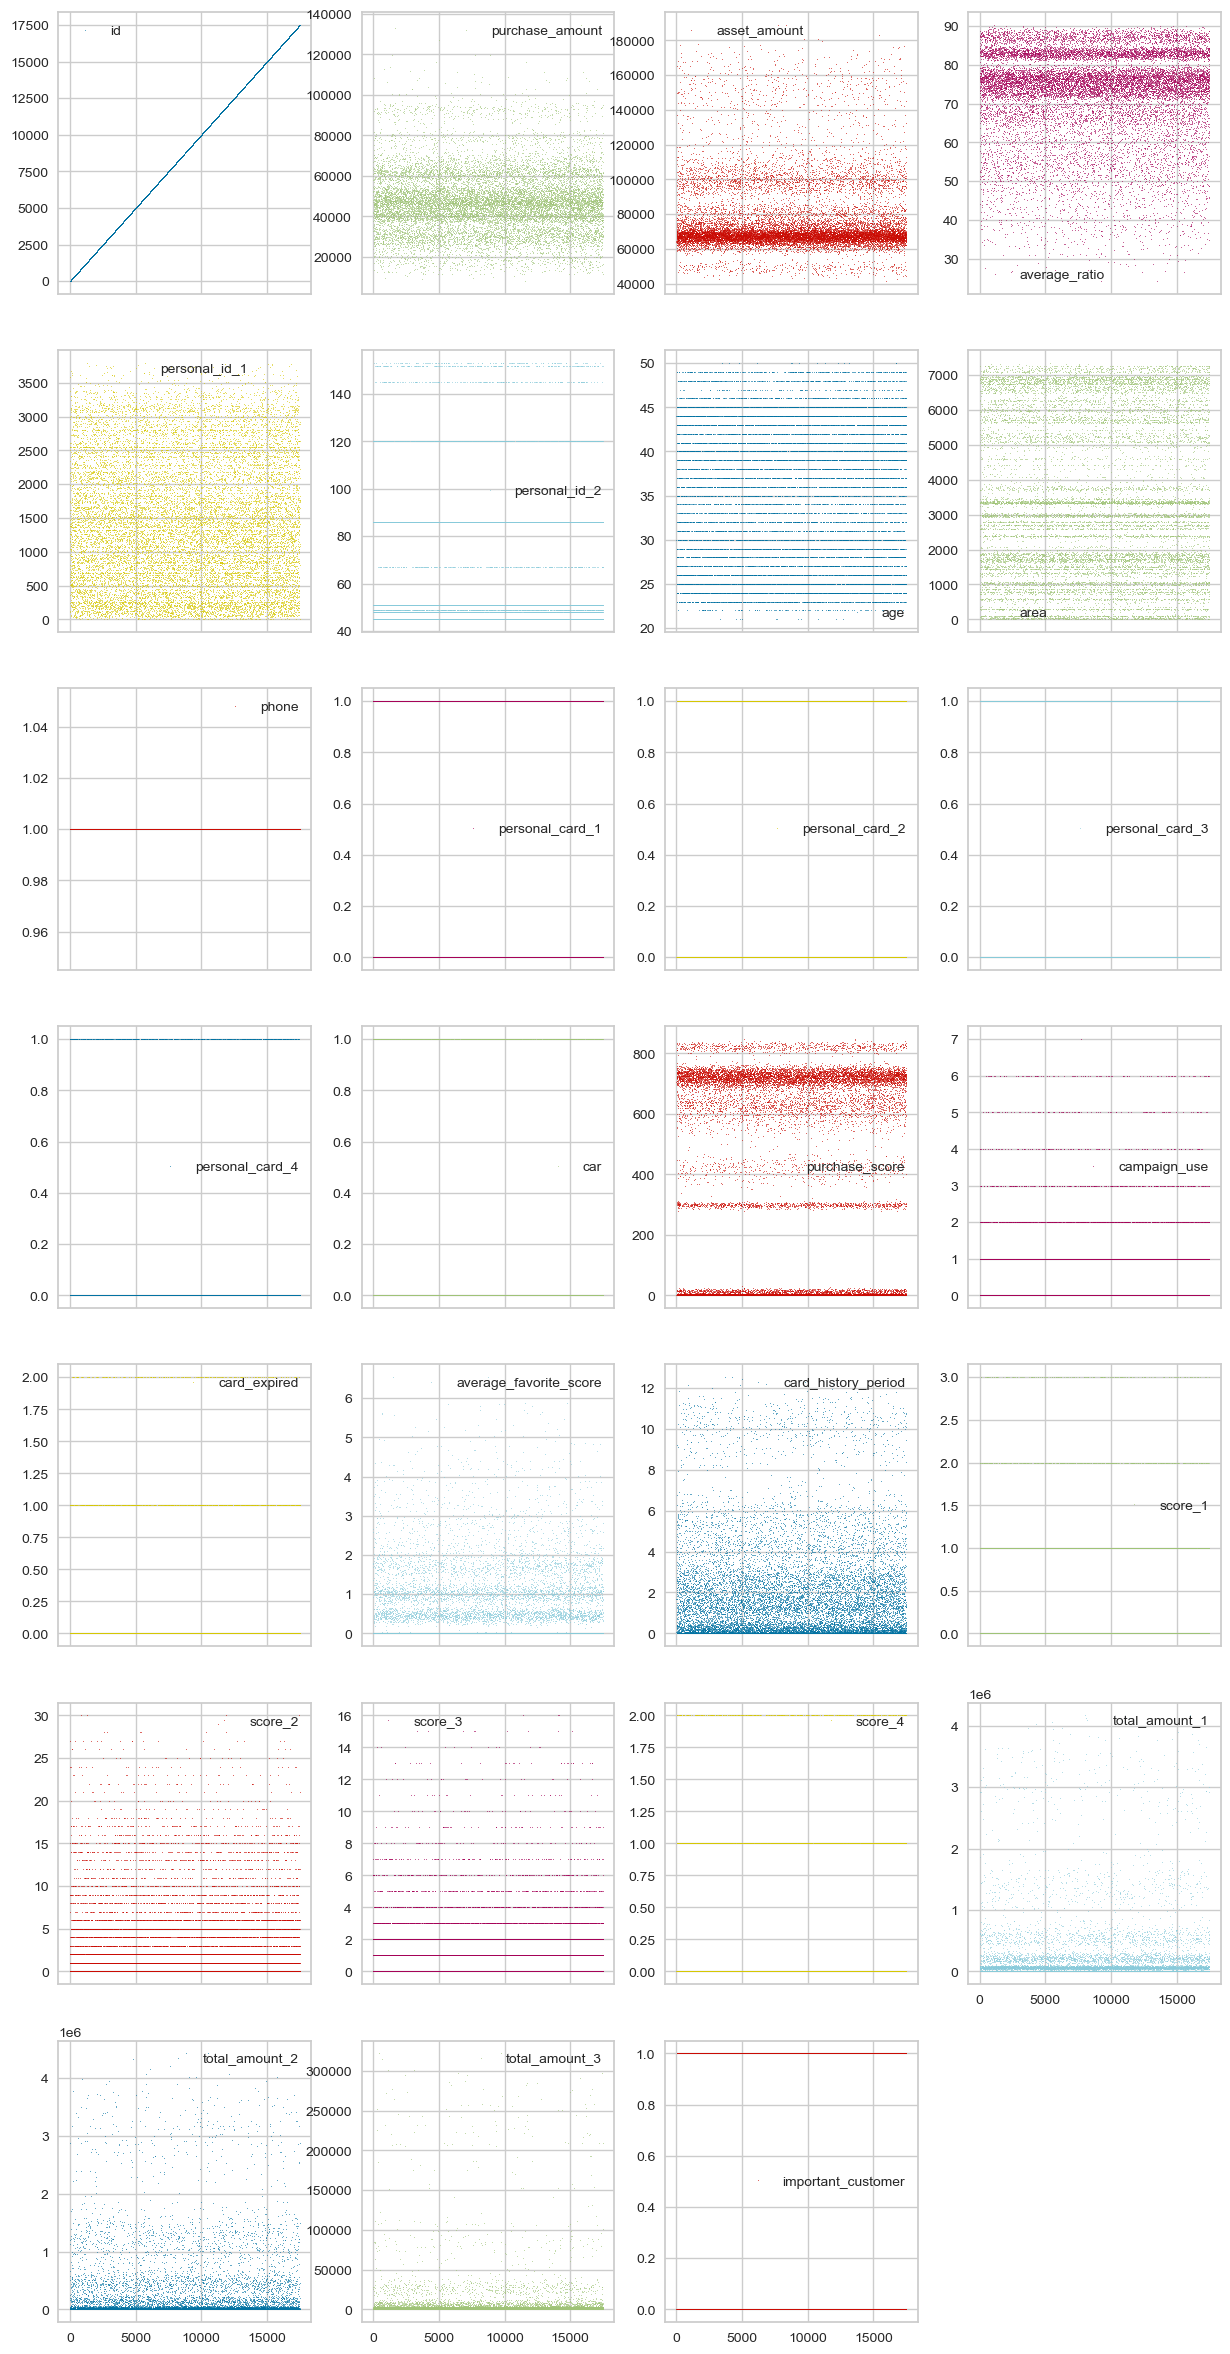

In [40]:
train_df.plot(lw=0, marker=".", subplots=True, layout=(-1, 4),
          figsize=(15, 30), markersize=1);

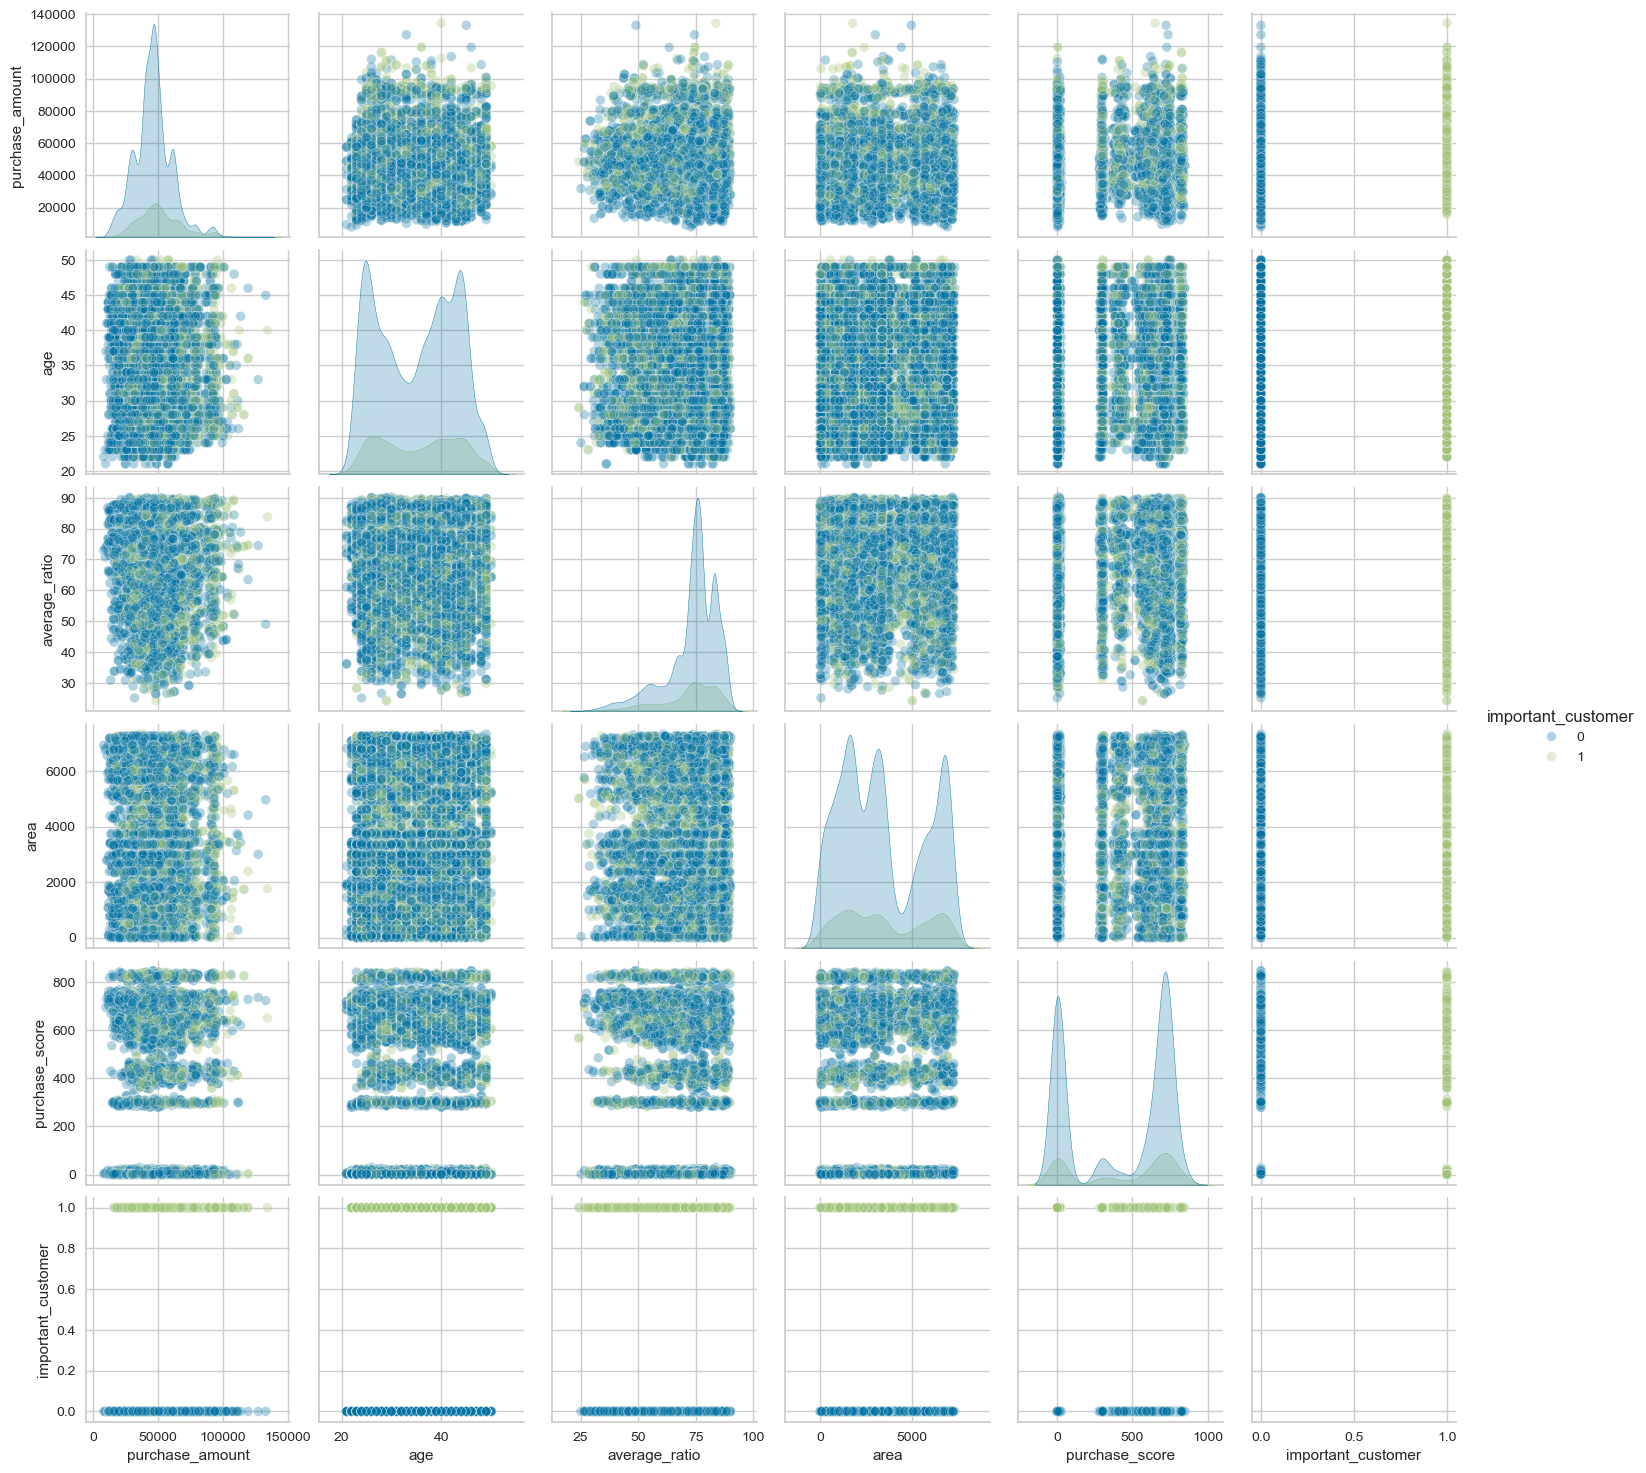

In [135]:
sns.pairplot(data=train_df, vars=["purchase_amount", "age", "average_ratio", "area", "purchase_score", "important_customer"], plot_kws={"alpha": 0.3}, hue="important_customer")
plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Getting rid of the useless features

Everybody has got the phone, the id is not important for the analysis and the job type was converted to self employed.

In [483]:
train_df["self_employed"] = (train_df["job_type"] == "Self employed").astype(int)
train_df = train_df.drop(["phone", "id", "job_type"], axis=1)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Linear correlations

We can't see any strong correlation between any of the features, only **card_history_period** and **average_favourite_score** seem to be quite related.

<Axes: >

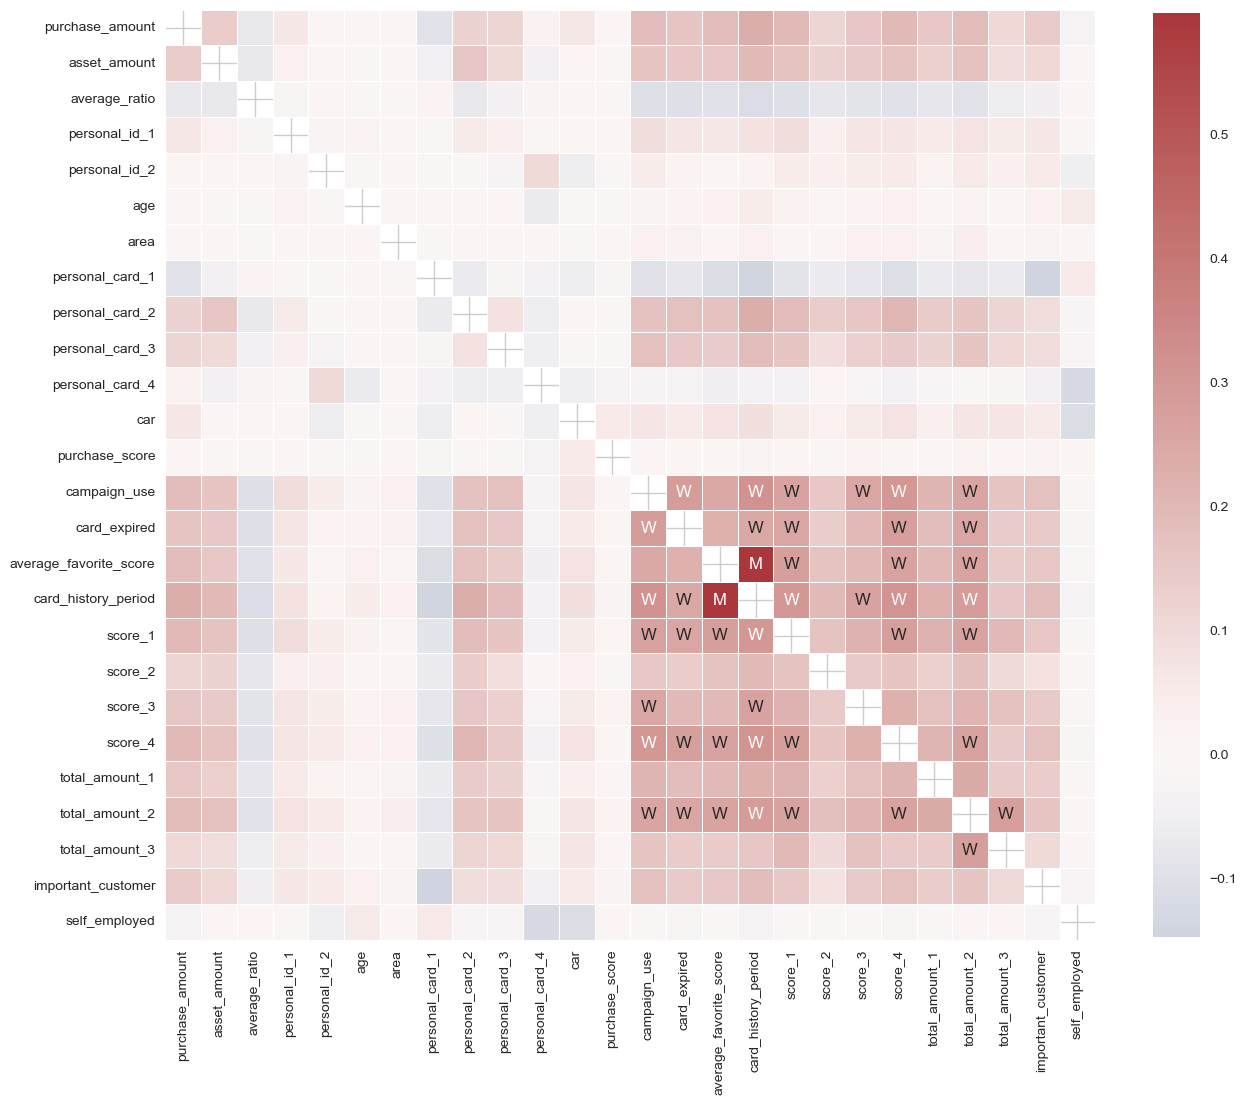

In [191]:
df_corr = train_df.select_dtypes(include="number").corr(method="pearson")

labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8})

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### There are a little bit more important customers that are not self employed

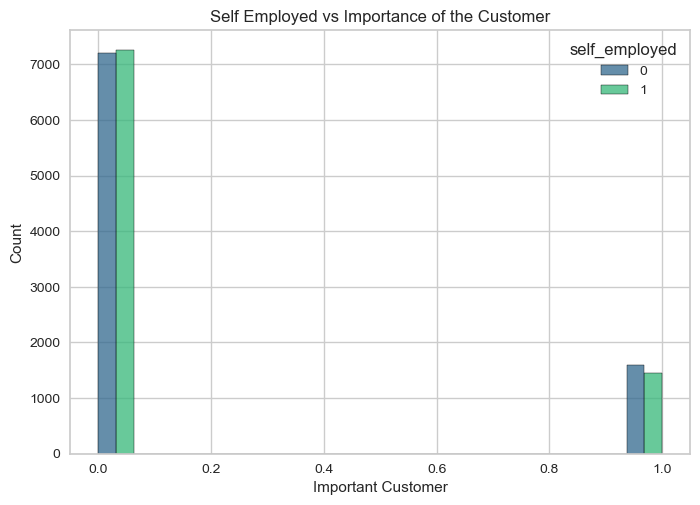

In [201]:
sns.histplot(data=train_df, x="important_customer", hue="self_employed", palette="viridis", multiple="dodge")
plt.title("Self Employed vs Importance of the Customer")
plt.xlabel("Important Customer")
plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Feature importances

I am going to stick with features on the right side of the line in RF Feature Importances.<br><r>
They also appear in Lasso FI, only making my decision stronger.

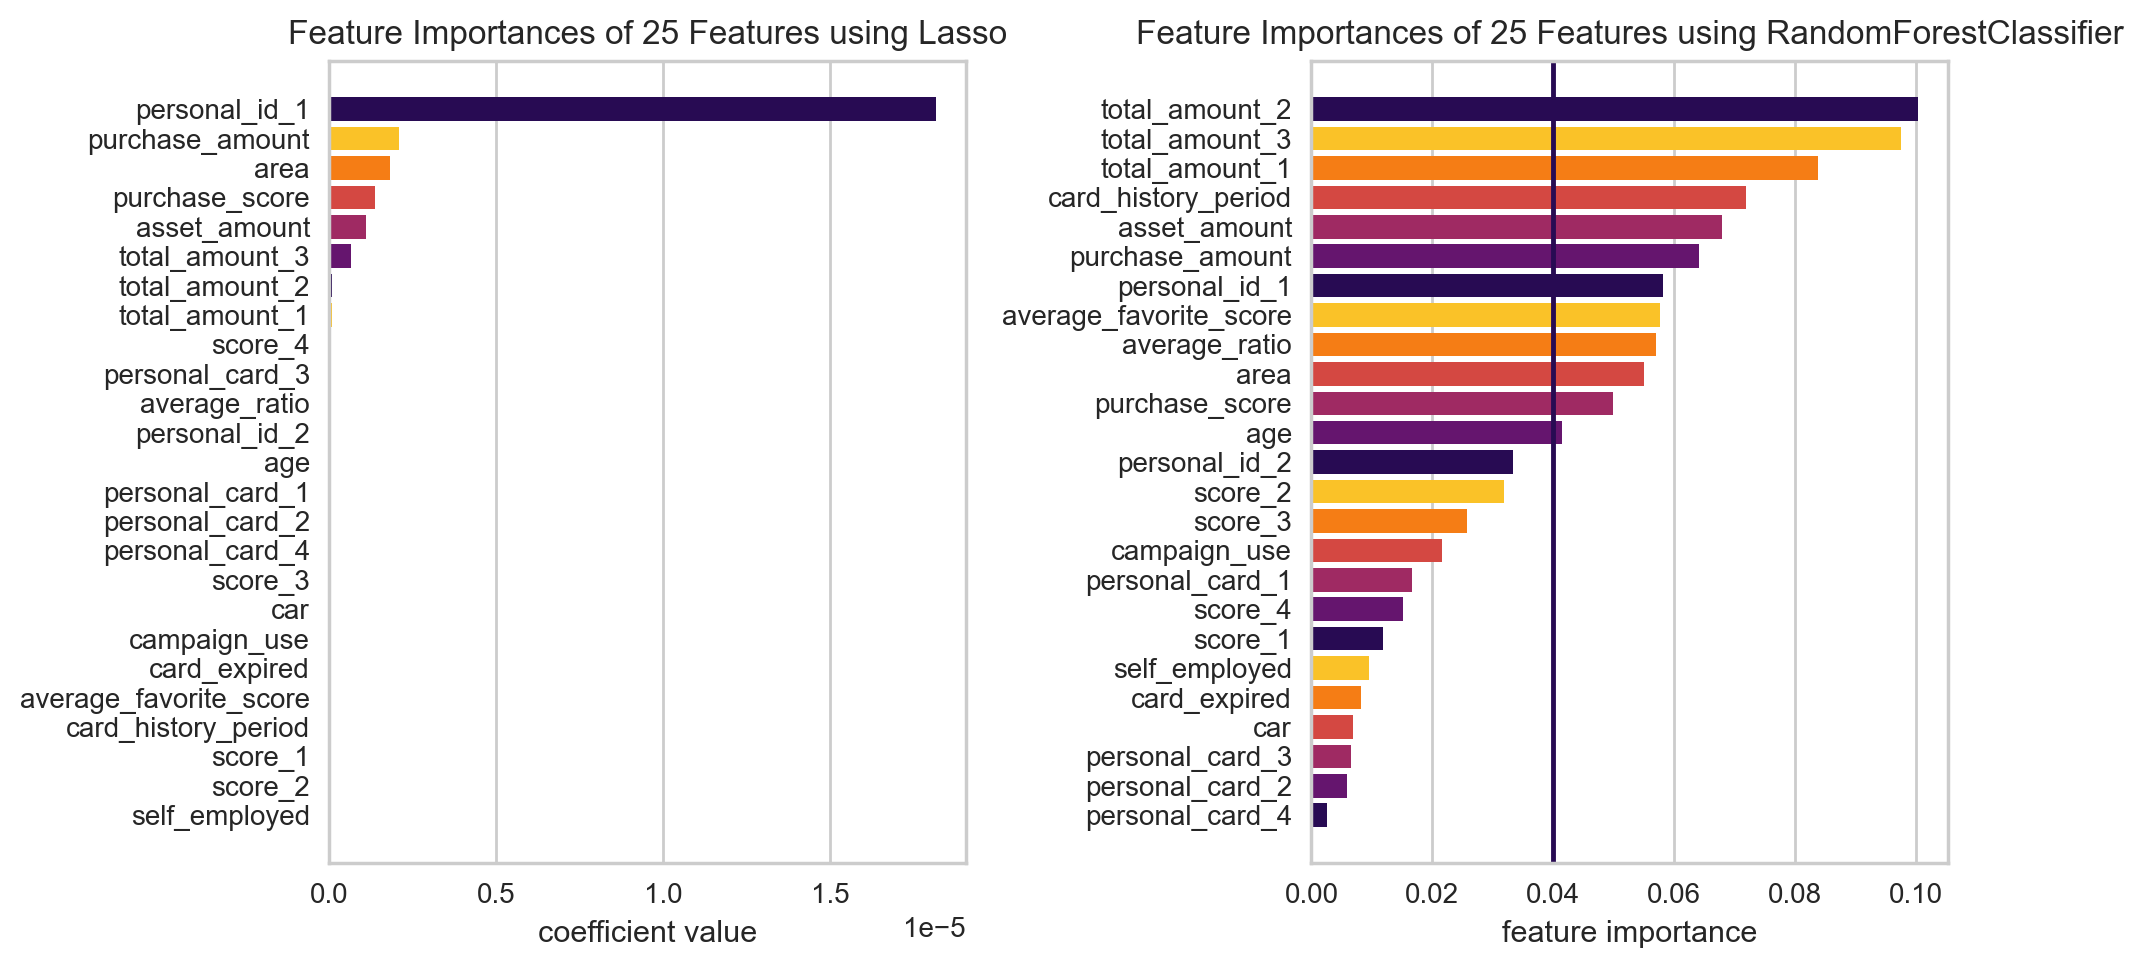

In [386]:
sns.set_palette("inferno")
nn_df = train_df.dropna()
X_fi = nn_df.drop(["important_customer"], axis=1)
y_fi = nn_df["important_customer"]

fig, axes = plt.subplots(ncols=2, figsize=(10, 5), dpi=200)

lasso_importance = Lasso()
rf_importance = RandomForestClassifier(n_estimators=200)

viz_lasso = FeatureImportances(lasso_importance, relative=False, ax=axes[0])
viz_lasso.fit(X_fi, y_fi)
viz_lasso.finalize()

viz_rf = FeatureImportances(rf_importance, relative=False, ax=axes[1])
viz_rf.fit(X_fi, y_fi)
viz_rf.finalize()

axes[1].axvline(x=0.04)

plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### Splitting the data and Missing values imputation

After Feature Selection, there are only 2 features with missing data. It makes it way easier to impute using some imputation algorythms like IterativeImputer (MICE).

In [485]:
features = ["total_amount_3", "total_amount_2", "total_amount_1",
            "card_history_period", "asset_amount", "purchase_amount",
            "average_favorite_score", "personal_id_1", "average_ratio",
            "area", "purchase_score", "age"]

target = "important_customer"

X = train_df[features]
y = train_df[target]

In [487]:
X.isna().sum().sort_values(ascending=False)

purchase_amount           1802
area                      1759
total_amount_3               0
total_amount_2               0
total_amount_1               0
card_history_period          0
asset_amount                 0
average_favorite_score       0
personal_id_1                0
average_ratio                0
purchase_score               0
age                          0
dtype: int64

In [489]:
mice_imputer = IterativeImputer()
X_full = mice_imputer.fit_transform(X)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Let's try to cluster the customers and see if we can find some patterns

I am going to reduce dimensions using PCA allowing me to make some more visual insights about potential clusters. In order to do so, I need to scale the data.<br><br>
Next I am going to use **The Elbow Rule** in order to specify the optimal amount of existing clusters.

In [398]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

In [400]:
pca = PCA(n_components=3) # in order to plot 3D graph
pca.fit(X_scaled)

PCA_df = pd.DataFrame(data=pca.transform(X_scaled), columns=(["X", "Y", "Z"]))

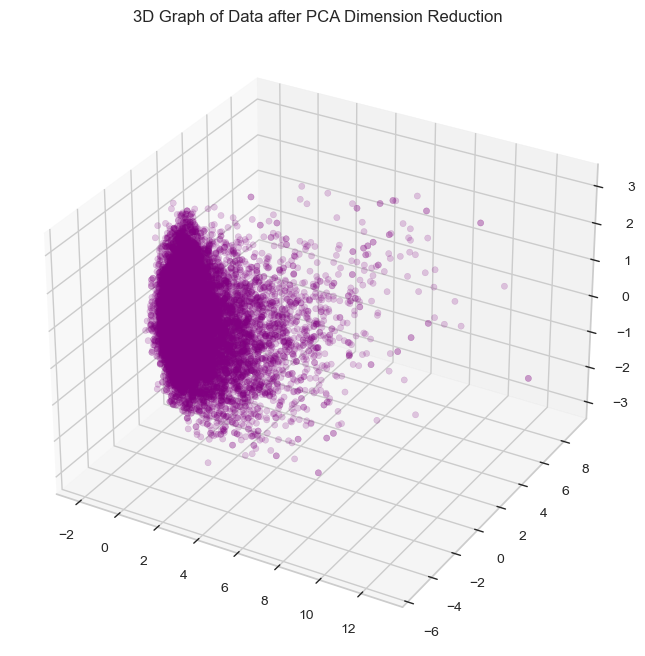

In [402]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(PCA_df["X"], PCA_df["Y"], PCA_df["Z"], c="purple", marker="o", alpha=0.2)
ax.set_title("3D Graph of Data after PCA Dimension Reduction")

plt.show()

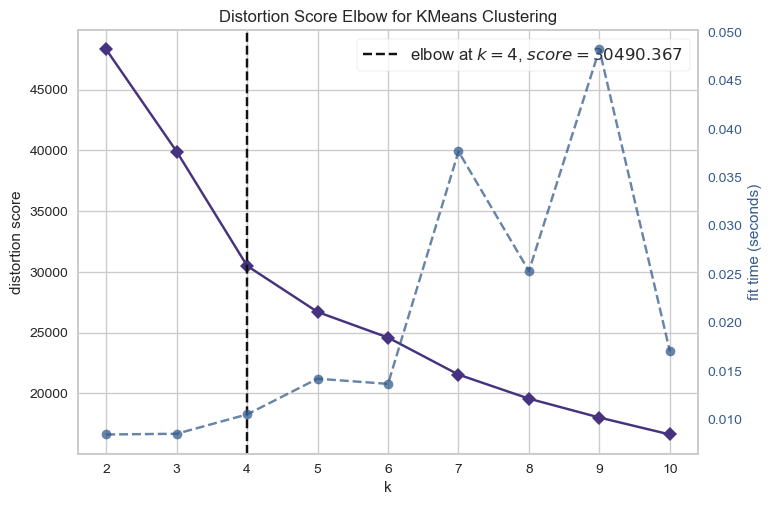

In [406]:
fig = plt.figure()

sns.set_palette("viridis")
elbow_viz = KElbowVisualizer(KMeans(), k=10)
elbow_viz.fit(PCA_df)
elbow_viz.show()

plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Clustering with Agglomerative Clustering

I didn't want the clusters to be similiar and spherical (KMeans), and wanted the algorythm that does not need any additional parametrization like (DBSCAN).

In [410]:
agg_cluster = AgglomerativeClustering(n_clusters=4)

y_agg = agg_cluster.fit_predict(PCA_df)

PCA_df["Cluster"] = y_agg
X["Cluster"] = y_agg

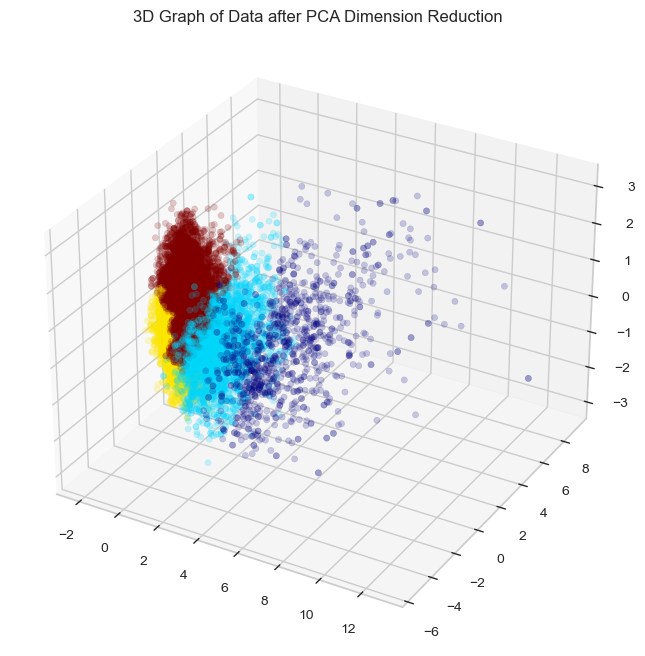

In [434]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(PCA_df["X"], PCA_df["Y"], PCA_df["Z"], c=PCA_df["Cluster"], marker="o", alpha=0.2, cmap="jet")
ax.set_title("3D Graph of Data after PCA Dimension Reduction")

plt.show()

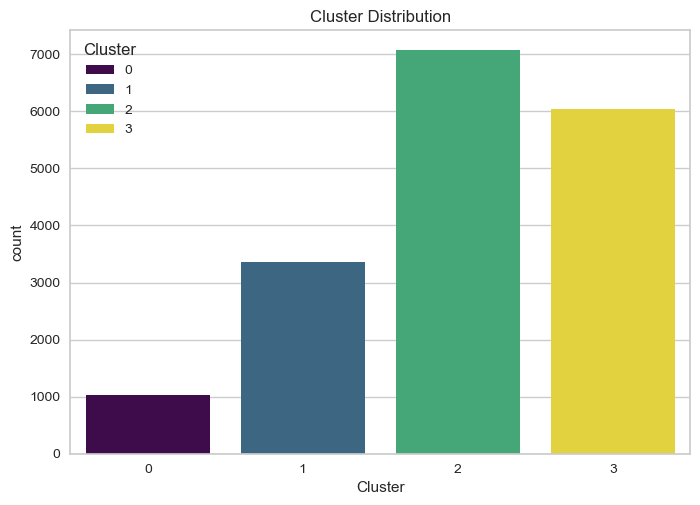

In [418]:
sns.countplot(data=X, x="Cluster", hue="Cluster", palette="viridis")
plt.title("Cluster Distribution")
plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Total Amounts variables across clusters

These three features were found most important by RF Feature Importance, I am going to see the spread in this dimension and compare it with the spread of Important Customers.<br><br>

However looking at the graph, there is not a pattern that could say something about cluster and target correlation.

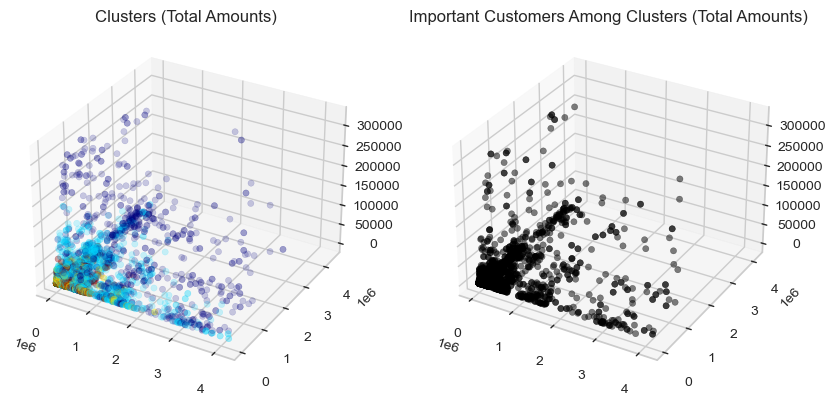

In [466]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

important_customers = X[y == 1]

ax1.scatter(X["total_amount_1"], X["total_amount_2"], X["total_amount_3"], c=X["Cluster"], marker="o", alpha=0.2, cmap="jet")
ax1.set_title("Clusters (Total Amounts)")

ax2.scatter(important_customers["total_amount_1"], important_customers["total_amount_2"], important_customers["total_amount_3"], c="black", marker="o", alpha=0.5)
ax2.set_title("Important Customers Among Clusters (Total Amounts)")

plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Age and Asset Amount across clusters

There are a minor patterns here, for example:

- Cluster No. 2 contains mostly young customers a little bit below the average asset amount
- Cluster No. 3 is made of mostly older customers, also a little bit under the average asset line
- Cluster No. 1 have the varied age customers, however more younger rather than older with a little bit above the average of asset line
- Cluster No. 0 varies in both dimensions, however mostly contains average-aged customers with the most of the asset amount, also containing some outliers

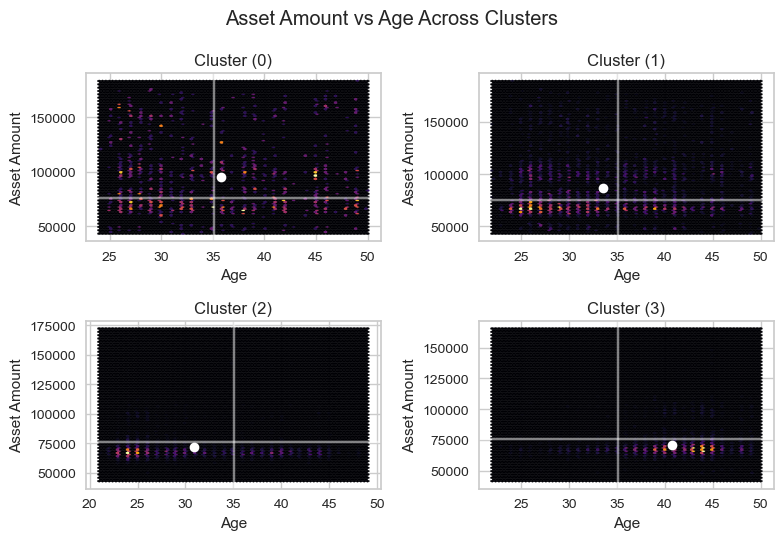

In [444]:
fig, axes = plt.subplots(nrows=2, ncols=2)

average_asset = X["asset_amount"].mean()
average_age = X["age"].mean()

for ax, cluster in zip(axes.flatten(), [0,1,2,3]):
    cluster_data = X[X["Cluster"] == cluster]

    avg_asset_cluster = cluster_data["asset_amount"].mean()
    avg_age_cluster = cluster_data["age"].mean()
    
    ax.hexbin(x=cluster_data["age"], y=cluster_data["asset_amount"], gridsize=80, cmap="inferno")
    ax.axhline(y=average_asset, c="white", alpha=0.5)
    ax.axvline(x=average_age, c="white", alpha=0.5)
    ax.plot(avg_age_cluster, avg_asset_cluster, "o", c="white", alpha=1)
    
    ax.set_title("Cluster (%d)" % cluster)
    ax.set_xlabel("Age")
    ax.set_ylabel("Asset Amount")

fig.suptitle("Asset Amount vs Age Across Clusters")
plt.tight_layout()
plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Classification problem

In [491]:
XX = pd.DataFrame(data=X_full, columns=features)
summary(XX).style.background_gradient(cmap='Greens')

In [493]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, stratify=y, test_size=0.15)

In [495]:
w0 = len(X_train) / (2 * len(y_train[y_train == 0]))
w1 = len(X_train) / (2 * len(y_train[y_train == 1]))

sample_weight = np.where(y_train == 1, w1, w0)

models = {
    "LogisticRegression": LogisticRegression(solver="newton-cholesky", class_weight="balanced"),
    "SVM": SVC(class_weight="balanced"),
    "RandomForestClassifier": RandomForestClassifier(class_weight="balanced"),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(algorithm='SAMME'),
    "XGBoostClassifier": xgb.XGBClassifier()
}

classes = ["imp", "not-imp"]

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Initial models evaluation

Looking at the initial evaluation, all the **Boosting Classifiers** seem to work well in this task, due to the fact I aim for the highest recall for **Important Customer** class.<br><br>

**Random Forest** fills the gap of the errors in other classifiers, so I will hyperparametrize all the **ensembles** except of **AdaBoost**, because it's just a little worse version of Gradient Boost.

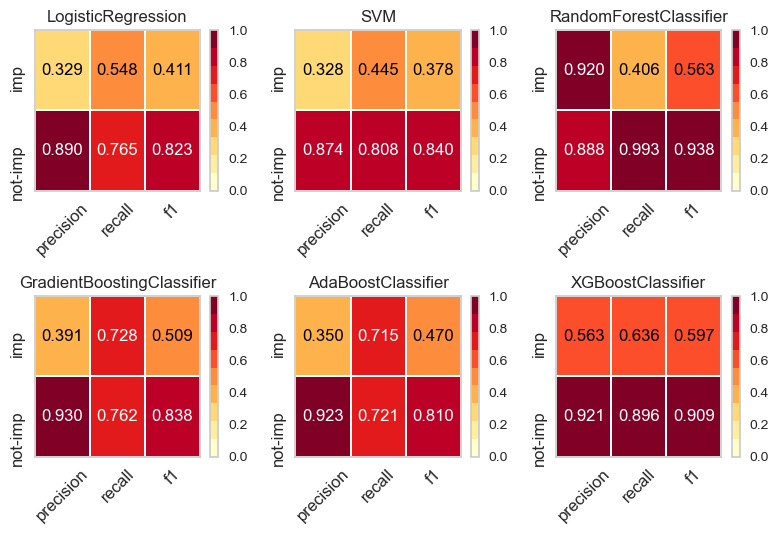

In [451]:
fig, axes = plt.subplots(nrows=2, ncols=3)

for ax, (name, model) in zip(axes.flatten(), models.items()):
    visualizer = ClassificationReport(model, ax=ax, classes=classes)
    if name in ["GradientBoostingClassifier", "AdaBoostClassifier", "XGBoostClassifier"]:
        visualizer.fit(X_train, y_train, sample_weight=sample_weight)
    else:
        visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    ax.set_title(name)
    ax.yaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

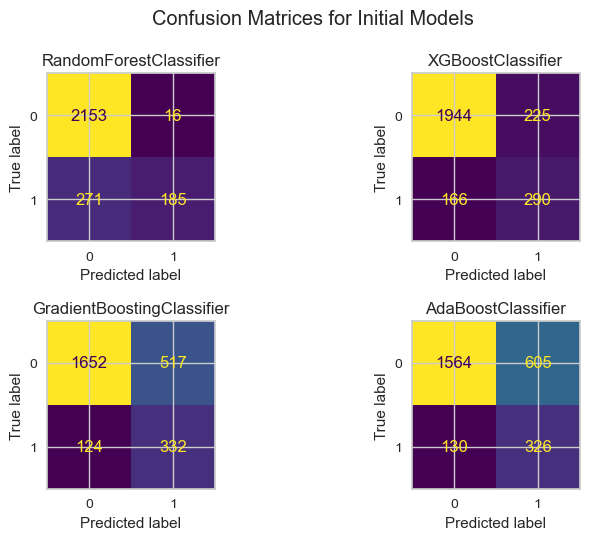

In [455]:
fig, axes = plt.subplots(ncols=2, nrows=2)

for ax, name in zip(axes.flatten(), ["RandomForestClassifier", "XGBoostClassifier", "GradientBoostingClassifier", "AdaBoostClassifier"]):
    y_pred = models[name].predict(X_test)
    plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    plot.plot(ax=ax, colorbar=False, cmap="viridis")
    ax.set_title(name)

fig.suptitle("Confusion Matrices for Initial Models")
plt.tight_layout()
plt.show()

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Hyperparametrization

---

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### Random Forest

Here I will decide which metric is going to be the best for me in this task.<br><br>

I will choose F1 score, because I actually picked RF only because it was great in precision, so I will keep it this way, however I will tune him a little more.

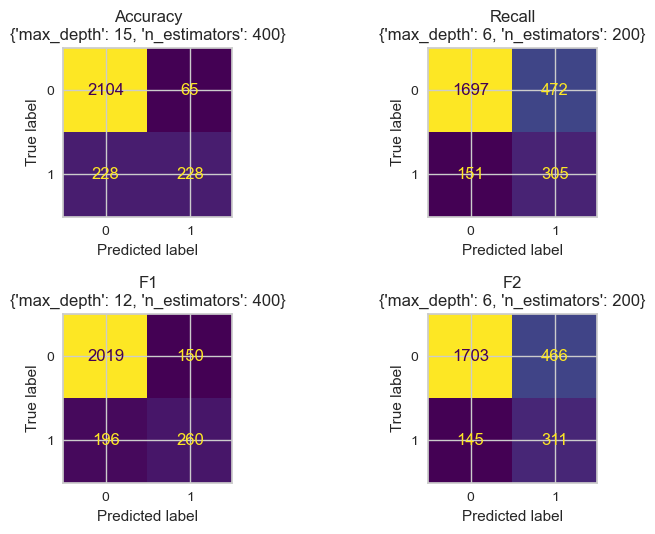

CPU times: total: 34.4 s
Wall time: 4min 36s


In [497]:
%%time

param_grid = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [3, 6, 9, 12, 15]
}

metrics = {
    "Accuracy": "accuracy",
    "Recall": "recall",
    "F1": "f1",
    "F2": f2_scorer
}

fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, (label, metric) in zip(axes.flatten(), metrics.items()):
    rf_cv = GridSearchCV(RandomForestClassifier(class_weight="balanced"),
                         param_grid,
                         n_jobs=-1,
                         scoring=metric)
    
    rf_cv.fit(X_train, y_train)

    y_pred = rf_cv.best_estimator_.predict(X_test)
    plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    plot.plot(ax=ax, colorbar=False, cmap="viridis")
    ax.set_title(f"{label}\n{rf_cv.best_params_}")

plt.tight_layout()
plt.show()

In [523]:
param_grid = {
    "max_samples": [1, 0.95, 0.9, 0.85]
}

rf_cv = GridSearchCV(RandomForestClassifier(class_weight="balanced", n_estimators=400, max_depth=12),
                     param_grid,
                     n_jobs=-1,
                     cv=10,
                     scoring="f1")

In [525]:
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=12, n_estimators=400),
             n_jobs=-1, param_grid={'max_samples': [1, 0.95, 0.9, 0.85]},
             scoring='f1')

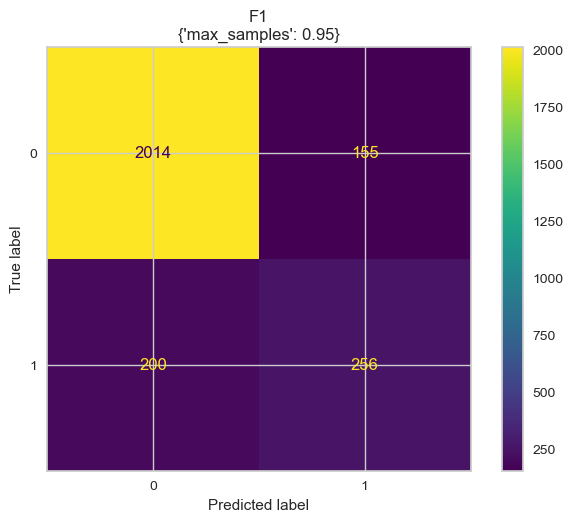

In [527]:
y_pred = rf_cv.best_estimator_.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title(f"F1\n{rf_cv.best_params_}")
plt.show() # got a little worse due to the randomness

In [529]:
rf_final = RandomForestClassifier(class_weight="balanced", max_depth=12, n_estimators=400, max_samples=0.95)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### Gradient Boost

While picking the scoring, I decided to go for a tuned version of F1 with the most attention for precision.

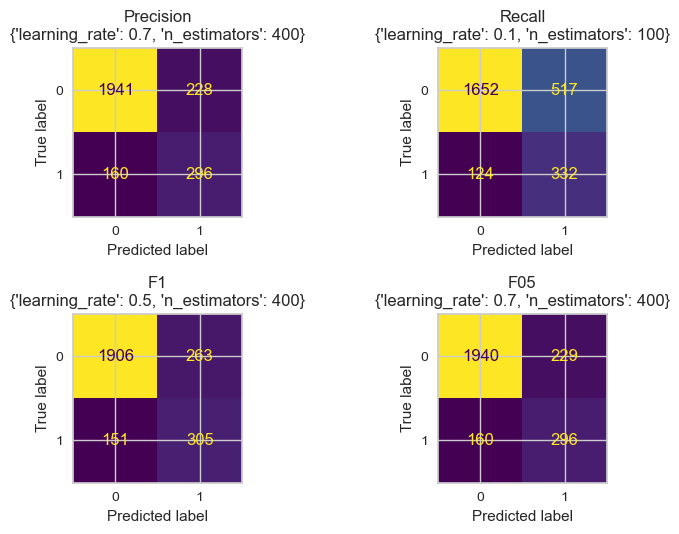

CPU times: total: 1min
Wall time: 6min 46s


In [531]:
%%time

param_grid = {
    "learning_rate": [0.1, 0.3, 0.5, 0.7],
    "n_estimators": [100, 200, 300, 400]
}

metrics = {
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "F05": f05_scorer
}

fig, axes = plt.subplots(nrows=2, ncols=2)

for ax, (label, metric) in zip(axes.flatten(), metrics.items()):
    gb_cv = GridSearchCV(GradientBoostingClassifier(),
                         param_grid,
                         n_jobs=-1,
                         scoring=metric)
    
    gb_cv.fit(X_train, y_train, sample_weight=sample_weight)

    y_pred = gb_cv.best_estimator_.predict(X_test)
    plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    plot.plot(ax=ax, colorbar=False, cmap="viridis")
    ax.set_title(f"{label}\n{gb_cv.best_params_}")

plt.tight_layout()
plt.show()

In [534]:
param_grid = {
    "learning_rate": [0.65, 0.7, 0.75],
    "n_estimators": [350, 400, 450],
    "max_features": [0.8, 0.9, None]
}

gb_cv = GridSearchCV(GradientBoostingClassifier(),
                     param_grid,
                     n_jobs=-1,
                     scoring=f2_scorer)

In [536]:
%%time
gb_cv.fit(X_train, y_train, sample_weight=sample_weight)

CPU times: total: 15.9 s
Wall time: 3min 33s


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.65, 0.7, 0.75],
                         'max_features': [0.8, 0.9, None],
                         'n_estimators': [350, 400, 450]},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=2))

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### GradientBoost - final model

The results after the second round of hypertuning are just a little worse than before, however I will choose these params, due to the max_features here being not None, what may lead to overall overfitting reduction.

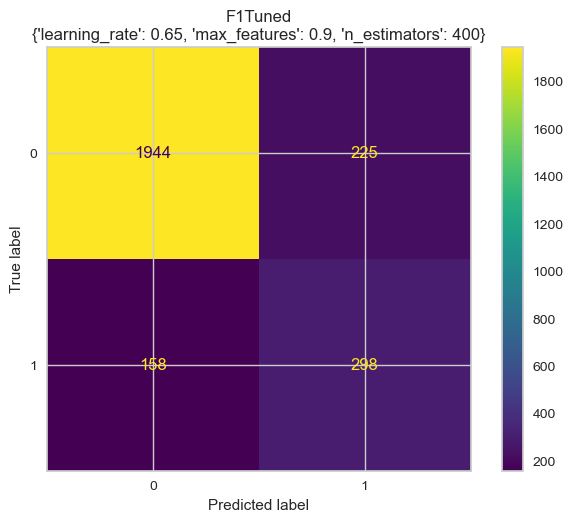

In [538]:
y_pred = gb_cv.best_estimator_.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.title(f"F1Tuned\n{gb_cv.best_params_}")
plt.show()

In [540]:
gb_final = GradientBoostingClassifier(learning_rate=0.65, max_features=0.9, n_estimators=400)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

### XGBoost

In [542]:
X_train_xgb, X_val_xgb, y_train_xgb, y_val_xgb = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

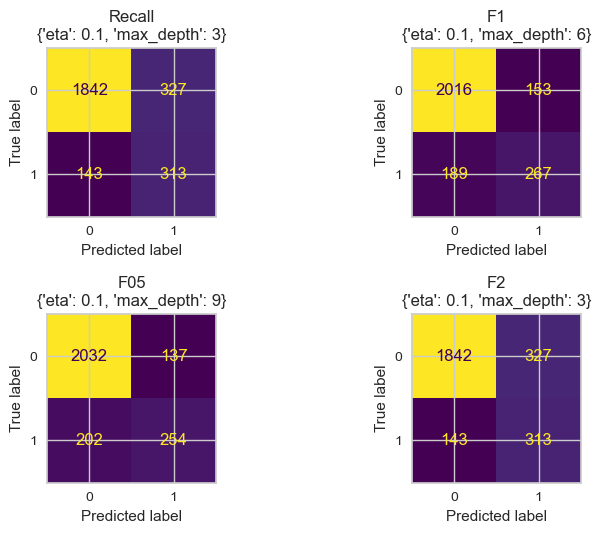

CPU times: total: 8.2 s
Wall time: 40.1 s


In [610]:
%%time

param_grid = {
    "eta": np.arange(0.1, 1, 0.1),
    "max_depth": [3, 6, 9, 16, 20]
}

metrics = {
    "Recall": "recall",
    "F1": "f1",
    "F05": f05_scorer,
    "F2": f2_scorer
}

w0_xgb = len(X_train_xgb) / (2 * len(y_train_xgb[y_train_xgb == 0]))
w1_xgb = len(X_train_xgb) / (2 * len(y_train_xgb[y_train_xgb == 1]))

sample_weight_xgb = np.where(y_train_xgb == 1, w1_xgb, w0_xgb)

fig, axes = plt.subplots(nrows=2, ncols=2)


xgb_cv = GridSearchCV(xgb.XGBClassifier(n_estimators=1000, early_stopping_rounds=30, eval_metric="logloss"),
                      param_grid,
                      n_jobs=-1,
                      scoring=metrics,
                      refit=False)
                          
    
xgb_cv.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weight_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)


results = xgb_cv.cv_results_

for ax, scorer in zip(axes.flatten(), metrics):
    best_index = np.argmax(results[f"mean_test_{scorer}"])
    best_params = results["params"][best_index]

    xgb_temp = xgb.XGBClassifier(n_estimators=1000, early_stopping_rounds=30, eval_metric="logloss",
                                 eta=best_params["eta"], max_depth=best_params["max_depth"])
    xgb_temp.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weight_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)

    y_pred = xgb_temp.predict(X_test)
    plot = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
    plot.plot(ax=ax, colorbar=False, cmap="viridis")
    ax.set_title(f"{scorer}\n{best_params}")

plt.tight_layout()
plt.show()    

In [642]:
%%time

param_grid = {
    "gamma": [0, 0.1, 0.3, 0.5, 0.7],
    "alpha": [0, 0.1, 0.3, 0.5, 0.7]
}

xgb_cv = GridSearchCV(xgb.XGBClassifier(eta=0.1, max_depth=3, n_estimators=1000, early_stopping_rounds=30, eval_metric="logloss"),
                      param_grid,
                      n_jobs=-1,
                      cv=5,
                      scoring="f1")

xgb_cv.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weight_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)

CPU times: total: 2.12 s
Wall time: 23.6 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=30,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=1000,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.3, 0.5, 0.7],
                         'gamma': [0, 0.1, 0.3, 0.5, 0.7]},
             scoring='f1')

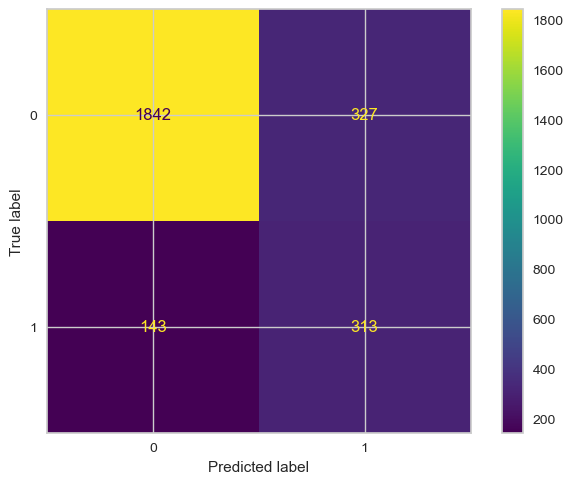

In [658]:
xgbb = xgb.XGBClassifier(eta=0.1, max_depth=3, n_estimators=1000, early_stopping_rounds=30, eval_metric="logloss")
xgbb.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weight_xgb, eval_set=[(X_val_xgb, y_val_xgb)], verbose=False)
y_pred = xgbb.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
ax.set_title(f"F2")
plt.show()

In [662]:
xgb_final = xgb.XGBClassifier(eta=0.1, max_depth=3,
                              alpha=0, gamma=0,
                              n_estimators=999)

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Model Stacking

I will try to connect the models in order to create a one that performs even better. I want to use VotingClassifier. However due to the limitation in VotingClassifier by scikit-learn, I need to implement my own simple one.

In [665]:
%%time
# all the models need a little tweak in fitting style

rf_final.fit(X_train, y_train) # Random Forest

gb_final.fit(X_train, y_train, sample_weight=sample_weight) # Gradient Boost

xgb_final.fit(X_train_xgb, y_train_xgb, sample_weight=sample_weight_xgb, verbose=False) #XGBoost

CPU times: total: 29.1 s
Wall time: 29.3 s


XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=999,
              n_jobs=None, ...)

In [667]:
class ModelVoting(BaseEstimator, ClassifierMixin):

    def __init__(self, rf_model: RandomForestClassifier, gb_model: GradientBoostingClassifier, xgb_model: xgb.XGBClassifier):
        if not all([isinstance(rf_model, RandomForestClassifier), isinstance(gb_model, GradientBoostingClassifier), isinstance(xgb_model, xgb.XGBClassifier)]):
            raise TypeError("Inappropriate models")
            
        self.rf_model = rf_model
        self.gb_model = gb_model
        self.xgb_model = xgb_model
        self.classes_ = np.array([0, 1])
        self.n_classes_ = 2


    def fit(self, X=None, y=None, sample_weight=None):
        check_is_fitted(self.rf_model)
        check_is_fitted(self.gb_model)
        check_is_fitted(self.xgb_model)

        return self
        

    def predict(self, X):
        y_pred_rf = self.rf_model.predict(X)
        y_pred_gb = self.gb_model.predict(X)
        y_pred_xgb = self.xgb_model.predict(X)

        preds = np.array([y_pred_rf, y_pred_gb, y_pred_xgb])
        final_predictions, _ = mode(preds, axis=0)

        return final_predictions


    def __sklearn_is_fitted__(self):
        return True

In [669]:
model_voting = ModelVoting(rf_final, gb_final, xgb_final)

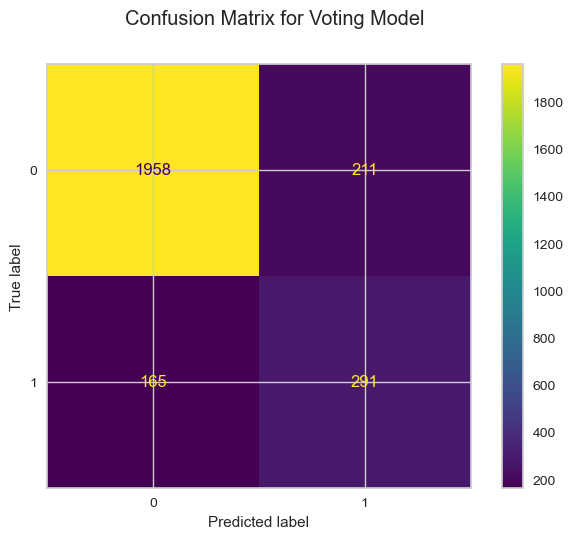

In [677]:
fig, ax = plt.subplots()

y_pred = model_voting.predict(X_test)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax)
fig.suptitle("Confusion Matrix for Voting Model")
plt.show()

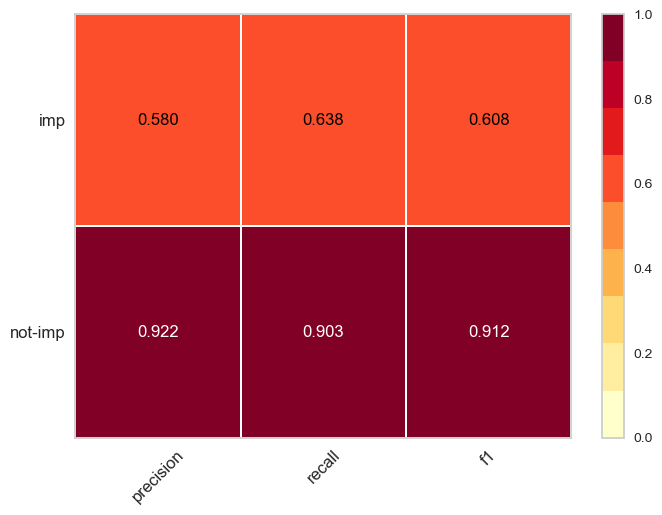

In [673]:
visualizer = ClassificationReport(model_voting, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
plt.show()

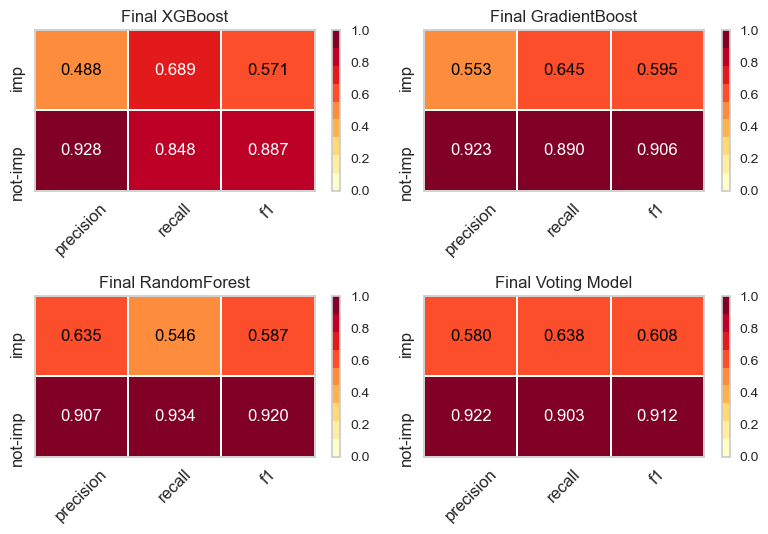

In [675]:
fig, axes = plt.subplots(nrows=2, ncols=2)

models_final = {
    "Final XGBoost": xgb_final,
    "Final GradientBoost": gb_final,
    "Final RandomForest": rf_final,
    "Final Voting Model": model_voting
}

for ax, (name, model) in zip(axes.flatten(), models_final.items()):
    visualizer = ClassificationReport(model, ax=ax, classes=classes)
    visualizer.score(X_test, y_test)
    ax.set_title(name)
    ax.yaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

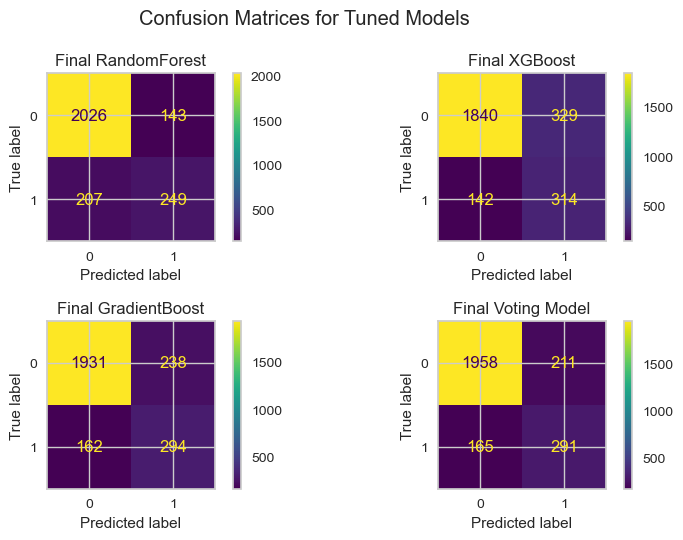

In [699]:
fig, axes = plt.subplots(nrows=2, ncols=2)

models_final = {
    "Final RandomForest": rf_final,
    "Final XGBoost": xgb_final,
    "Final GradientBoost": gb_final,
    "Final Voting Model": model_voting
}

for ax, (name, model) in zip(axes.flatten(), models_final.items()):
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(ax=ax)
    ax.set_title(name)

fig.suptitle("Confusion Matrices for Tuned Models")
plt.tight_layout()
plt.show()

fig.savefig("graphs/confusions_tuned.png")

<div style="background: rgb(71, 71, 107); padding-left: 10px; border: 1px solid black; font-family: Monospace; border-radius: 15px; box-shadow: 2px 2px 0px 0px rgba(0,0,0,0.7); color: white;">

# Evaluation on test sample

In [679]:
test_df = pd.read_csv("data/test_df.csv")
test_df.head()

ids = test_df["id"]

In [681]:
features_selector = ColumnTransformer(
    transformers=[
        ("selector", "passthrough", features)
    ],
    remainder="drop"
)

In [683]:
column_transformer = Pipeline([
    ("select_columns", features_selector),
    ("imputer", mice_imputer)
])

In [685]:
column_transformer.fit(X_train)

Pipeline(steps=[('select_columns',
                 ColumnTransformer(transformers=[('selector', 'passthrough',
                                                  ['total_amount_3',
                                                   'total_amount_2',
                                                   'total_amount_1',
                                                   'card_history_period',
                                                   'asset_amount',
                                                   'purchase_amount',
                                                   'average_favorite_score',
                                                   'personal_id_1',
                                                   'average_ratio', 'area',
                                                   'purchase_score',
                                                   'age'])])),
                ('imputer', IterativeImputer())])

In [687]:
test = pd.DataFrame(data=column_transformer.transform(test_df), columns=features)

In [689]:
y_final = model_voting.predict(test)

In [691]:
submision = pd.DataFrame({"id": ids.values, "important_customer": y_final})

In [693]:
submision.to_csv("submision1.csv", index=False)